# How an Analysis is implemented

In the previous tutorial we modeled fibroblast-macrophage dynamics as follows:

/Users/jonathansomer/Documents/phd/projects/tumor-dynamical-modeling/src/tdm/raw/breast_mibi.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[DIVISION_COL] = is_dividing(
/Users/jonathansomer/Documents/phd/projects/tumor-dynamical-modeling/src/tdm/raw/breast_mibi.py:405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[X_COL] = microns(df[X_COL])
/Users/jonathansomer/Documents/phd/projects/tumor-dynamical-modeling/src/tdm/raw/breast_mibi.py:406: SettingWithCopyWarning: 
A value is trying to be set o

1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


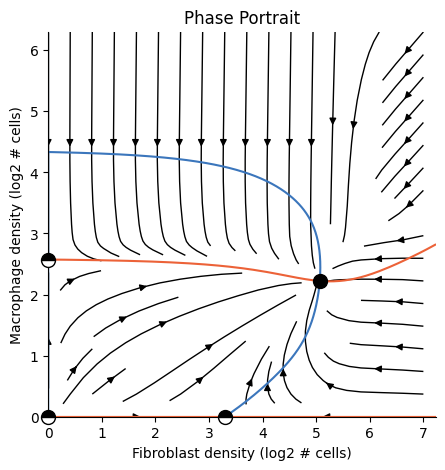

In [2]:
from tdm.raw.breast_mibi import read_single_cell_df
from tdm.cell_types import FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL
from tdm.analysis import Analysis
from tdm.plot.two_cells.phase_portrait import plot_phase_portrait

single_cell_df = read_single_cell_df()

ana = Analysis(
    single_cell_df=single_cell_df,
    cell_types_to_model=[FIBROBLAST, MACROPHAGE],
    allowed_neighbor_types=[FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL],
    polynomial_dataset_kwargs={"degree":2,},
    neighborhood_mode='extrapolate',
)

plot_phase_portrait(ana)

In this tutorial we'll understand what's happening under the hood by getting to know the three primary OSDR classes:

1. `Tissue`
2. `Dataset`
3. `Model`

The three classes are used as part of an ordered pipeline. We transform the single-cell dataframe into one `Tissue` per image, then into a `Dataset` and finally into a `Model`

# 1. The Tissue

A `Tissue` represents a single real-life slide. 

In a `Tissue`, cells with similar `x,y` positions will be neighbors. As opposed to cells from the single-cell dataframe, that might have a similar `x,y` value but can arrive from different patients or tissue sections. 

We can access and plot the first tissue in our analysis as follows:

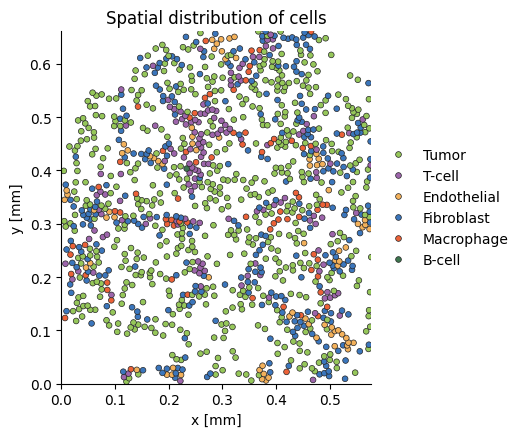

In [3]:
from tdm.plot.tissue import plot_tissue

tissue = ana.tissues[0]
plot_tissue(tissue)


Note: The `plot_tissue` function has a few useful utilities for debugging, such as plotting circular neighborhoods at specific locations. For more details, go to the Examples section in the docs.


## Each `Tissue` exposes a few useful properties:

In [4]:
tissue.subject_id

'MB-0282'

In [5]:
tissue.img_id

1

In [6]:
cell_df = tissue.cell_df() # the rows of single_cell_df corresponding with this tissue
cell_df.head(3)

,x,y,division,cell_type,img_id,subject_id
0,0.000121,0.000004,False,Tu,1,MB-0282
1,0.000222,0.000005,False,T,1,MB-0282
2,0.000354,0.000006,False,Tu,1,MB-0282


In [7]:
tissue.cell_types()

['Tu', 'T', 'En', 'F', 'M', 'B']

In [8]:
tissue.tissue_dimensions() # maximal x,y values

(0.000577658536585366, 0.000660847826086957)

Check out the docs for more.

# 2. The Dataset

## A `Dataset` object organizes the features and labels for the various cell types

The OSDR dynamical model relies on modeling the relation between division rate and composition of a cell's neighborhood.

For example, in the fibroblast-macrophage model the dynamics for fibroblasts can be written as:

$$
\frac{dF}{dt} = F\cdot (p_F^+(F,M) - p_F^-(F,M))
$$

Where $p_F^+,p_F^-$ are statistical models that map the density of fibroblasts and macrophages to fibroblast division or death rates. 

To fit the model $p^+_F$ we construct: 

1. a table of features ("X") based on the densities of fibroblasts and macrophages
2. a vector of binary labels ("y") for observations of cell-division.

Note that because different cell types respond to different growth factors we need to fit a separate model for each cell type. 

A `Dataset` object organizes the features and labels for the various cell types. 

To access the features and labels for a specific cell type, use the `dataset.fetch(cell_type)` function:

In [9]:
neighbors_dataset = ana.nds
features, labels = neighbors_dataset.fetch(cell_type='F')

In [10]:
# densities of the various cell types:
features.head(3)

,Tu,T,En,F,M,B
0,20.373117,2.037312,12.223870,25.447740,0.0,0.0
1,26.634353,1.664647,6.658588,12.652530,0.0,0.0
2,15.285997,1.698444,8.492221,19.682886,0.0,0.0


In [11]:
# binary cell-division events:
labels.head(3)

,division
0,False
1,False
2,False


The `Dataset` class is the base class for several classes that implement the `.fetch(cell_type)` API. 

An `Analysis` typicaly makes use of multiple datasets one after another.

The following steps are performed by the `Analysis` class in the fibroblast-macrophage analysis:

In [12]:
from tdm.dataset import ExtrapolateNeighborsDataset, ConcatDataset, RestrictedNeighborsDataset, PolynomialDataset

tissues = ana.tissues

# 1. count the number of neighbors for each cell in each tissue:
ndss = [ ExtrapolateNeighborsDataset(t) for t in tissues]

# 2. concatenate features and labels from different tissues:
nds = ConcatDataset(ndss)

# 3. filter cells:
rnds = RestrictedNeighborsDataset(
    nds, 
    allowed_neighbor_types=[FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL], 
    keep_types=[FIBROBLAST, MACROPHAGE] # derived from the cell_types_to_model argument for Analysis
)

# 4. tranform features:
pds = PolynomialDataset(rnds, degree=2, log_transform=False, scale_features=False)

The features from the manual pipeline above are equal to those from the `Analysis` object:

In [13]:
features, labels = pds.fetch('F')
features.head(3)

,1,F,M,F^2,F M,M^2
0,1.0,5.484926,1.494975,30.084414,8.199829,2.234951
1,1.0,7.306431,1.261286,53.383937,9.215501,1.590843
2,1.0,14.000000,0.000000,196.000000,0.000000,0.000000


In [14]:
features, labels = ana.pds.fetch(FIBROBLAST)
features.head(3)

,1,F,M,F^2,F M,M^2
0,1.0,5.484926,1.494975,30.084414,8.199829,2.234951
1,1.0,7.306431,1.261286,53.383937,9.215501,1.590843
2,1.0,14.000000,0.000000,196.000000,0.000000,0.000000


## Summarizing the steps for preparing the final `Dataset` used to fit a `Model`:

1. We first use `NeighborsDataset` or `ExtrapolateNeighborsDataset` to count the number of neighbors of each cell in every tissue. The list of neighbors datasets for each cell type is accessible via `ana.ndss`. 
    * Providing `Analysis` with the argument `neighborhood_mode='exclude'` will use `NeighborsDataset`, excluding cells whose neighborhoods exceed tissue limites. 
    * Alternatively, providing `Analysis` with the argument `neighborhood_mode='extrapolate'` will use `ExtrapolateNeighborsDataset`, including all cells in the tissue, while scaling the cell counts according to the fraction of the neighborhood that's observed.
2. We use `ConcatDataset` to concatenate the cell counts from the separate tissues (accessible via `ana.nds`)
3. We use `RestrictedDataset` to filter out cells we don't wish to model or cells with unallowed neighbors (accessible via `ana.rnds`)
4. We use `PolynomialDataset` to introduce interaction terms between the raw cell-counts. This is also the class that transforms or scales features. (accessible via `ana.pds`)

Each dataset receives the previous as its primary input. Finally, a `Model` is fit to an instance of `PolynomialDataset`.


# 3. The Model

## The `Model` fits probabilistic models of division and death rates for each cell type

The OSDR `Model` emulates the `.fit`, `.predict` api from packages such as sklearn. 

But instead of fitting just one model, `Model` fits models for division and death per cell type.

Essentially, `Model` does the following:

```python
for cell_type in dataset.cell_types():
    features, labels = dataset.fetch(cell_type)
    model.fit(features, labels)
```

## To predict the probability of a division or death event we use the `.predict` function:


In [15]:
model = ana.model
features, labels = ana.pds.fetch('F')

model.predict(
    cell_type='F', 
    obs='division', 
    features=features.head(3)
)

array([0.02096666, 0.01832152, 0.01025308])

## To predict changes in cell numbers we use the `delta_cells` function:

`Model` also has a useful method for directly computing the expected difference in the number of cells of each type (e.g $dF/dt$), based on the current cell counts:

In [16]:
# Important! delta_cells expects raw cell counts and not features:
model.delta_cells(cell_counts={FIBROBLAST: [100], MACROPHAGE: [50]}, return_order=['F', 'M'])

array([-51.13920971, -26.05025259])

In [17]:
# we can also compute the difference between division and death rates:
model.delta_cells(cell_counts={FIBROBLAST: [100], MACROPHAGE: [50]}, return_order=['F', 'M'], mode='rates')

array([-0.5113921 , -0.52100505])


## The death rate is estimated as a constant

Recall, we need probabilistic models for both division and death. In practice, because reliable death markers are lacking, we fit a probabilistic model only for division and we approximate the death rate as a constant. 

We approximate the death rate with a constant approximately equal to the mean death rate. The mean death rate is expected to be close to the mean division rate in datasets that are derived from a large number of patients because at the population level we expect the numbers of cells to be relatively stable. That is, there shouldn't be a rapid exponential rise in T-cells accross an entire population (even if their number is exponentially rising in some individuals). 

Note: 

* If the data is derived from a single individual following an acute event, then the total cell population might be rapidly rising or shrinking. In this cases we can't approximate the death rate as the mean division rate and approximation of the death rate needs to be done through markers or through prior knowledge of death rates in similar instances. 
* If we are comparing subsets of patients, then it is better to compute a shared death rate from both subsets together, and use that rate in the models for both groups. If we take the mean division rate as the death rate in each group separately we inadvertently "normalize-out" the differences in division rates between the two groups.  

In [18]:
model.death_prob(FIBROBLAST)

0.011392097090435505

In [19]:
model.predict(
    cell_type=FIBROBLAST, 
    obs='death', 
    features=features.head(3)
)

array([0.0113921, 0.0113921, 0.0113921])